In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import glob
import math
import torch as t

import matplotlib.pyplot as plt

from src.utils.data.datasets.epf import EPF, EPFInfo
from src.utils.numpy.metrics import rmae, mae, mape, smape, rmse, gwtest, plot_GW_test_pvals
from src.utils.numpy.metrics import GW_CPA_test

In [2]:
def compute_loss(name, y, y_hat, y_hat_baseline):
    if name == 'rmae':
        return rmae(y=y, y_hat1=y_hat, y_hat2=y_hat_baseline)
    if name == 'mae':
        return mae(y=y, y_hat=y_hat)
    if name == 'smape':
        return smape(y=y, y_hat=y_hat)
    if name == 'rmse':
        return rmse(y=y, y_hat=y_hat)

In [3]:
def epf_naive_forecast(Y_df):
    """Function to build the naive forecast for electricity price forecasting
    
    The function is used to compute the accuracy metrics MASE and RMAE, the function
    assumes that the number of prices per day is 24. And computes naive forecast for
    days of the week and seasonal Naive forecast for weekends.
        
    Parameters
    ----------
    Y_df : pandas.DataFrame
        Dataframe containing the real prices in long format
        that contains variables ['ds', 'unique_id', 'y']
    
    Returns
    -------
    Y_hat_df : pandas.DataFrame
        Dataframe containing the predictions of the epf naive forecast.
    """
    assert type(Y_df) == pd.core.frame.DataFrame
    assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])    

    # Init the naive forecast
    Y_hat_df = Y_df[24 * 7:].copy()
    Y_hat_df['dayofweek'] = Y_df['ds'].dt.dayofweek
    
    # Monday, Saturday and Sunday 
    # we have a naive forecast using weekly seasonality
    weekend_indicator = Y_hat_df['dayofweek'].isin([0,5,6])
    
    # Tuesday, Wednesday, Thursday, Friday 
    # we have a naive forecast using daily seasonality
    week_indicator = Y_hat_df['dayofweek'].isin([1,2,3,4])

    naive = Y_df['y'].shift(24).values[24 * 7:]
    seasonal_naive = Y_df['y'].shift(24*7).values[24 * 7:]
    
    Y_hat_df['y_hat'] = naive * week_indicator + seasonal_naive * weekend_indicator
    return Y_hat_df

# EVALUATION VARIABLES

In [4]:
DATASET = 'NP' # NP, PJM, BE, FR, DE
METRIC = 'MAE'
ENSEMBLE = True
esrnn = 'esrnn'
nbeats = 'nbeats'
nbeatsx_i = 'nbeats_x_interpretable'
nbeatsx_g = 'nbeats_x'

In [5]:
days = 728

TEST_DATE = {'NP': '2016-12-27',
             'PJM':'2016-12-27',
             'BE':'2015-01-04',
             'FR': '2015-01-04',
             'DE':'2016-01-04'}

test_date = TEST_DATE[DATASET]
Y_df, X_df, _ = EPF.load_groups(directory='./data', groups=[DATASET])

y_insample_df = Y_df[Y_df['ds']<test_date].reset_index(drop=True)
X_t_insample_df = X_df[X_df['ds']<test_date].reset_index(drop=True)
y_outsample_df = Y_df[Y_df['ds']>=test_date].reset_index(drop=True)
X_t_outsample_df = X_df[X_df['ds']>=test_date].reset_index(drop=True)

y_insample = y_insample_df['y']
y_outsample = y_outsample_df['y']

Y_df = y_insample_df.append(y_outsample_df).reset_index(drop=True)
y_hat_naive = epf_naive_forecast(Y_df=Y_df)
y_hat_naive = y_hat_naive['y_hat'][-len(y_outsample):].values

# LOAD RESULTS

In [6]:
y_hat_dicts = pickle.load(open(f'./results/forecasts/{DATASET}/forecasts_single.p', 'rb'))
ensemble_dicts = pickle.load(open(f'./results/forecasts/{DATASET}/forecasts_ensemble.p', 'rb'))

# BEST SINGLE MODEL

In [7]:
dict_losses = {}
best_models = {}
for key in y_hat_dicts.keys():
    dict_losses[key] = {}
    best_models[key] = {}
    for loss in ['mae', 'rmae', 'smape', 'rmse']:
        min_loss = 1_000

        for run in y_hat_dicts[key]:
            run_loss = np.round(compute_loss(name=loss, y=y_outsample, y_hat=y_hat_dicts[key][run],
                                y_hat_baseline=y_hat_naive), 2)
            
            if run_loss < min_loss:
                dict_losses[key][loss] = run_loss
                best_models[key][loss] = [y_hat_dicts[key][run]]
                min_loss = run_loss

print('\n'*2)
print(f'Best single models, {DATASET} dataset')
pd.DataFrame(dict_losses)




Best single models, NP dataset


,ar,esrnn,nbeats,arx,lear,dnn,nbeatsx_g,nbeatsx_i
mae,2.28,2.11,2.11,2.11,1.95,1.71,1.65,1.68
rmae,0.72,0.67,0.67,0.67,0.62,0.54,0.52,0.53
smape,6.51,6.09,6.05,6.10,5.62,4.97,4.84,4.89
rmse,4.08,3.92,3.98,3.84,3.60,3.36,3.27,3.33


# ENSEMBLE MODEL

In [8]:
dict_ensemble_losses = {}
for key in ensemble_dicts.keys():
    dict_ensemble_losses[key] = {}
    for loss in ['mae', 'rmae', 'smape', 'rmse']:
        if len(ensemble_dicts[key])>0:
            dict_ensemble_losses[key][loss] = np.round(compute_loss(name=loss, y=y_outsample, y_hat=ensemble_dicts[key],
                                y_hat_baseline=y_hat_naive), 2)
        else:
            dict_ensemble_losses[key][loss] = None

print('\n'*2)
print(f'Ensembled models, {DATASET} dataset')
pd.DataFrame(dict_ensemble_losses)




Ensembled models, NP dataset


,ar,esrnn,nbeats,arx,lear,dnn,nbeatsx_g,nbeatsx_i
mae,2.26,2.09,2.08,2.01,1.74,1.68,1.58,1.62
rmae,0.71,0.66,0.66,0.63,0.55,0.53,0.50,0.51
smape,6.47,6.04,5.96,5.84,5.01,4.88,4.63,4.70
rmse,4.08,3.89,3.94,3.71,3.36,3.32,3.16,3.27


# GW TEST

In [9]:
def mean_daily_errors(y, y_hat, metric):
    if metric=='MAE':
        return np.mean(np.abs(y - y_hat), axis=1)
    if metric=='RMSE':
        return np.sqrt(np.mean(np.square(y - y_hat), axis=1))
    else:
        print(f'Metric {metric} not implemented')
        assert 1<0

best_data = pd.DataFrame({'AR1': best_models['ar'][METRIC.lower()][0],
                          'ARX1': best_models['arx'][METRIC.lower()][0],
                          'LEAR': best_models['lear'][METRIC.lower()][0], 
                          'DNN': best_models['dnn'][METRIC.lower()][0], 
                          'ESRNN': best_models['esrnn'][METRIC.lower()][0],
                          'NBEATS': best_models['nbeats'][METRIC.lower()][0], 
                          'NBEATSx-G': best_models['nbeatsx_g'][METRIC.lower()][0],
                          'NBEATSx-I': best_models['nbeatsx_i'][METRIC.lower()][0],
                          'y':y_outsample})

ensemble_data = pd.DataFrame({'AR1': ensemble_dicts['ar'],
                              'ARX1': ensemble_dicts['arx'],
                              'LEAR': ensemble_dicts['lear'],
                              'DNN': ensemble_dicts['dnn'],
                              'ESRNN': ensemble_dicts['esrnn'],
                              'NBEATS': ensemble_dicts['nbeats'],
                              'NBEATSx-G': ensemble_dicts['nbeatsx_g'],
                              'NBEATSx-I': ensemble_dicts['nbeatsx_i'],
                              'y':y_outsample})

In [10]:
if ENSEMBLE:
    data = ensemble_data
else:
    data = best_data

errors = data.copy()

errors = errors.iloc[::24, :]
del errors['y']

ordered_models = ['AR1', 'ESRNN', 'NBEATS', 'ARX1', 'LEAR', 'DNN', 'NBEATSx-G', 'NBEATSx-I']
errors = errors[ordered_models]
for model in errors.columns:
    errors.loc[:, model] = mean_daily_errors(y=data['y'].to_numpy().reshape(-1, 24),
                                             y_hat=data[model].to_numpy().reshape(-1, 24),
                                             metric=METRIC)

pvals = pd.DataFrame(index=errors.columns, columns=errors.columns)

for model1 in pvals.index:
    for model2 in pvals.columns:
        pvals.loc[model1, model2] = gwtest(loss1=errors.loc[:, model1].values, 
                                           loss2=errors.loc[:, model2].values)
pvals

,AR1,ESRNN,NBEATS,ARX1,LEAR,DNN,NBEATSx-G,NBEATSx-I
AR1,1,3.48138e-05,1.46791e-05,2.22045e-16,0,0,0,0
ESRNN,1,1,0.30869,0.0519224,5.55112e-16,0,0,0
NBEATS,1,1,1,0.0625486,2.2482e-13,0,0,0
ARX1,1,1,1,1,1.36668e-13,2.22045e-16,0,0
LEAR,1,1,1,1,1,0.0866358,7.07362e-08,9.65403e-05
DNN,1,1,1,1,1,1,0.000130647,0.0387265
NBEATSx-G,1,1,1,1,1,1,1,1
NBEATSx-I,1,1,1,1,1,1,0.0569027,1


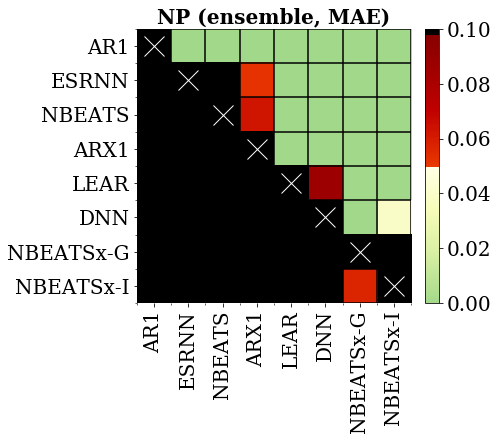

In [11]:
title_ensemble = 'ensemble' if ENSEMBLE else 'single'
title = DATASET + ' (' + title_ensemble + ', ' + METRIC + ')'
plot_GW_test_pvals(pvals=pvals, labels=ordered_models, title=title)